In [64]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

from hermes.purchasability import (get_purchasability_zinc,
                                           get_purchasability_enamine,
                                           get_purchasability_mcule,
                                           get_purchasability_emolecules,
                                  get_zinc_ids)

from ro5utils.db import asyncio_query_ro5db, query_ro5db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Links to files

In [2]:
project_dir = Path("/Users/povilas/projects/2021-10_Strateos/IRAK/")

In [3]:
irak_data_raw = pd.read_csv(project_dir/'irak14_joint.csv')

In [4]:
# Need to get IRAK1 data!

irak1_data =[{'smiles': 'COc1cc(ccc1NC(=O)c2cccc(n2)c3ccn[nH]3)N4CCOCC4',
              "activity_type": 'IC50',
              "-log10_activity_irak1": -np.log10(9.3*10**-9),
              "-log10_activity_irak4": None}]
irak1_data_df = pd.DataFrame(irak1_data)

irak1_pdb_data = [{'smiles': 'COc1cc(ccc1NC(=O)c2cccc(n2)c3ccn[nH]3)N4CCOCC4',
                   'irak1_pdb': ['6BFN'],
                   'irak1_pdb_no':1}]
irak1_pdb_df = pd.DataFrame(irak1_pdb_data)

In [5]:
irak_data = pd.concat([irak_data_raw, irak1_data_df])

In [6]:
# Load PDB data
with open(project_dir/'irak4_pdbs.json') as fh:
    irak4_pdb = json.load(fh)
irak4_pdb_df = pd.DataFrame.from_dict(irak4_pdb, orient='index')
irak4_pdb_df.index.name = 'smiles'
irak4_pdb_df = irak4_pdb_df.reset_index()
irak4_pdb_df = irak4_pdb_df.rename(columns={'pdbs':'irak4_pdb'})
irak4_pdb_df['irak4_pdb_no']= irak4_pdb_df['irak4_pdb'].apply(lambda x: len(x))
irak4_pdb_df = irak4_pdb_df.drop(columns=['std_values'])

In [7]:
irak4_data_pdb = pd.merge(irak_data, irak4_pdb_df, on='smiles', how='outer')
irak_data_pdb = pd.merge(irak4_data_pdb, irak1_pdb_df, on='smiles', how='outer')


In [8]:
irak_data_pdb = irak_data_pdb.sort_values('-log10_activity_irak1', ascending=False)

In [98]:
irak_data_pdb.to_csv(project_dir/'irak14_pdbs.csv')

# Puchasability

In [9]:
from smilite import get_zincid_from_smile, create_id_smile_list
from rdkit import Chem as Chem
import urllib
import wget
import os

In [10]:
smiles = "c1ccc(COc2ccc(Nc3ncnc4ccccc34)cc2)cc1"

In [11]:
m = Chem.MolFromSmiles(smiles)

In [12]:
m

In [16]:
smiles_canon = Chem.CanonSmiles(smiles)
assert smiles == smiles_canon

In [17]:
cmd = get_callback(smiles, tanimoto = 1.0, version=12)

In [18]:
request_match(smiles)

(1, (None, None))

In [19]:
all_smiles = irak_data_pdb['smiles'].to_list()

In [20]:
?get_zincid_from_smile

Signature: get_zincid_from_smile(smile_str, backend='zinc15')
Docstring:
Gets the corresponding ZINC ID(s) for a SMILE string query from
the ZINC online database. Requires an internet connection.

Keyword arguments:
    smile_str (str): A valid SMILE string, e.g.,
        C[C@H]1CCCC[NH+]1CC#CC(c2ccccc2)(c3ccccc3)O'
    backend (str): Specifies the database backend, "zinc12" or "zinc15"

Returns the SMILE string for the corresponding ZINC ID(s) in a list.
    E.g., ['ZINC01234567', 'ZINC01234568', 'ZINC01242053', 'ZINC01242055']
File:      ~/opt/anaconda3/envs/hermes/lib/python3.9/site-packages/smilite/smilite.py
Type:      function


In [22]:
get_zincid_from_smile("CCO", backend='zinc15')

['ZINC000012358605']

## Test smilite

In [65]:
zinc_results_df2 = get_zinc_ids(irak_data_pdb['smiles'])

 14%|███████████████▏                                                                                           | 410/2894 [13:05<1:19:21,  1.92s/it]


KeyboardInterrupt: 

In [46]:
zinc_results_df

zinc_id
COc1cc(ccc1NC(=O)c2cccc(n2)c3ccn[nH]3)N4CCOCC4                                     [ZINC000029046611]
COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)NC(=O)C(C)(C)O4)n...                                 [ZINC000006745792]
Cc1cc(Nc2ncc(F)c(NC3C4C=CC(C4)C3C(N)=O)n2)ccc1N...  [ZINC000063298059, ZINC000068045356, ZINC00007...
O=C(Nc1nc2cc(CN3CCCCC3)ccc2n1-c1ccc(CCO)cc1)c1c...                                 [ZINC000117542784]
COc1cc(C=C(C#N)c2nc3cc(C)ccc3[nH]2)c(Br)cc1O                     [ZINC000004494446, ZINC000005125847]
...                                                                                               ...
Oc1cc([C@H]2C3CCC(CC3)[C@@H]2Nc2nc(-c3c[nH]c4nc...                                 [ZINC000299862618]
OC1CCN(c2ncnc3[nH]cc(-c4ccccc4)c23)CC1                                             [ZINC000063298151]
OCC(O)[C@H]1C2CCC(CC2)[C@@H]1Nc1nc(-c2c[nH]c3nc...               [ZINC000299869660, ZINC000299869661]
OCCCCNc1cc(-c2c[nH]c3ncccc23)cc(Cl)n1                                              [ZINC000063539780]
OCCNc1cc(-c2c[nH]c3ncccc23)cc(Cl)n1                                                [ZINC000063539778]

[2894 rows x 1 columns]

In [47]:
zinc_results_df.to_csv(project_dir/'zinc_query.csv')

In [15]:
query_ro5db("SELECT * FROM ro5molecule.emolecules LIMIT 3")

canonical_isomeric_smiles
0  Cc1ccc(OCC(=O)Nc2nc(-c3ccc(Cl)cc3)ns2)c(C)c1
1      Cc1ccc(OCC(=O)NC(C)c2ccc3ccccc3c2)c(C)c1
2    Cc1ccc(OCC(=O)NCc2ccc(-c3ncsc3C)cc2)c(C)c1

In [48]:
# Get purchaseability data
# TODO: Get emolecules presence
purch_zinc = get_purchasability_zinc(irak_data_pdb['smiles'].to_list(), chunk_size=50, running_in_jupyter=True)
purch_enamine = get_purchasability_enamine(irak_data_pdb['smiles'].to_list(), chunk_size=50, running_in_jupyter=True)
purch_mcule = get_purchasability_mcule(irak_data_pdb['smiles'].to_list(), chunk_size=50, running_in_jupyter=True)
purch_emolecules = get_purchasability_emolecules(irak_data_pdb['smiles'].to_list(), chunk_size=50, running_in_jupyter=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:20<00:00,  1.39s/it]


In [66]:
irak_data_pdb_purch = pd.concat([irak_data_pdb,
                                 purch_emolecules.reset_index(drop=True),
                                 zinc_results_df.reset_index(drop=True),
                                 purch_zinc.drop(columns=['in_zinc']).reset_index(drop=True),
                                 purch_enamine.drop(columns=['zinc_id']).reset_index(drop=True),
                                 purch_mcule.reset_index(drop=True),
                                 purch_emolecules.reset_index(drop=True)],
                                axis=1)

In [69]:
irak_data_pdb_purch.to_csv(project_dir/'irak14_pdbs_purchasability.csv')

In [55]:
#irak_data_pdb_purch = pd.read_csv(project_dir/'irak14_pdbs_purchaseability.csv', index_col=0).set_index('smiles')

In [83]:
irak_data_pdb_purch = irak_data_pdb_purch.astype({'-log10_activity_irak1': 'float', '-log10_activity_irak4': 'float'})

In [84]:
irak_data_pdb_purch.sort_values("-log10_activity_irak1", ascending=False).head(20)

smiles activity_type  \
2893     COc1cc(ccc1NC(=O)c2cccc(n2)c3ccn[nH]3)N4CCOCC4          IC50   
352   COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)NC(=O)C(C)(C)O4)...            Ki   
107   Cc1cc(Nc2ncc(F)c(NC3C4C=CC(C4)C3C(N)=O)n2)ccc1...            Ki   
595   O=C(Nc1nc2cc(CN3CCCCC3)ccc2n1-c1ccc(CCO)cc1)c1...            Ki   
344        COc1cc(C=C(C#N)c2nc3cc(C)ccc3[nH]2)c(Br)cc1O            Ki   
345           COc1cc(C=C(C#N)c2nc3ccccc3[nH]2)c(Br)cc1O            Ki   
213   CCc1cc2c(cc1-c1cnn(CC(=O)N(C)C)c1)C(C)(C)c1[nH...          IC50   
214   CCc1cc2c(cc1-c1cnn(CCCN(C)C)c1)C(C)(C)c1[nH]c3...          IC50   
225   CCCCn1c(NC(=O)c2cccc(C#N)c2)nc2cc(N(C)C(=O)C3C...            Ki   
600   O=C(Nc1nc2cc(CN3CCCCC3)ccc2n1[C@H]1CC[C@H](O)C...            Ki   
602       O=C(Nc1nc2ccccc2n1CCCO)c1cccc([N+](=O)[O-])c1            Ki   
649   O=C1Nc2ccc3ncsc3c2C1=CNc1ccc(S(=O)(=O)Nc2ccccn...            Ki   
22    CC(=O)N1CCN([C@H]2CC[C@H](Nc3ncnn4ccc(C(C)C)c3...          IC50   
18    c1nc(N[C@H]2CC[C@H](N3CCOCC3)CC2)c2c(C3CCOCC3)...          IC50   
458   N#CCOc1ccc(Nc2nc(Nc3cccc(S(N)(=O)=O)c3)ncc2Br)cc1            Ki   
536       NS(=O)(=O)c1cccc(Nc2ncc3ccn(-c4ccccc4)c3n2)c1            Ki   
328   CNS(=O)(=O)c1ccccc1Nc1nc(Nc2cc(N3CCN(C(C)=O)CC...            Ki   
593   O=C(Nc1n[nH]c2ccc(-c3cn(Cc4ccccc4)nn3)cc12)c1c...            Ki   
488               NC1CCCCC1Nc1nccc(-c2c[nH]c3ncccc23)n1            Ki   
598   O=C(Nc1nc2cc(CN3CCCCC3)ccc2n1[C@H]1CC[C@@H](CO...            Ki   

      -log10_activity_irak1  -log10_activity_irak4 irak4_pdb  irak4_pdb_no  \
2893               8.031517                    NaN    [6EGE]           1.0   
352                8.000000               7.199971       NaN           NaN   
107                8.000000               7.100015       NaN           NaN   
595                7.920819               8.886057       NaN           NaN   
344                7.899974               5.700001       NaN           NaN   
345                7.899974               5.300000       NaN           NaN   
213                7.853872               6.332547       NaN           NaN   
214                7.823909               6.630784       NaN           NaN   
225                7.799971               7.000000       NaN           NaN   
600                7.744727               8.552842       NaN           NaN   
602                7.700057               7.100015       NaN           NaN   
649                7.700057               5.800001       NaN           NaN   
22                 7.677781               7.659953       NaN           NaN   
18                 7.638272               8.301030    [5K76]           1.0   
458                7.599980               6.900009       NaN           NaN   
536                7.500038               7.299989       NaN           NaN   
328                7.500038               7.199971       NaN           NaN   
593                7.500038               5.599999       NaN           NaN   
488                7.400008               8.299989       NaN           NaN   
598                7.318759               9.154902       NaN           NaN   

     irak1_pdb  irak1_pdb_no  in_emolecules  \
2893    [6BFN]           1.0          False   
352        NaN           NaN           True   
107        NaN           NaN          False   
595        NaN           NaN          False   
344        NaN           NaN          False   
345        NaN           NaN          False   
213        NaN           NaN          False   
214        NaN           NaN          False   
225        NaN           NaN          False   
600        NaN           NaN          False   
602        NaN           NaN          False   
649        NaN           NaN          False   
22         NaN           NaN          False   
18         NaN           NaN          False   
458        NaN           NaN          False   
536        NaN           NaN          False   
328        NaN           NaN          False   
593        NaN           NaN  

In [88]:
from plotnine import aes, ggplot, geom_point, scale_x_continuous

/Users/povilas/opt/anaconda3/envs/hermes/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2283 rows containing missing values.


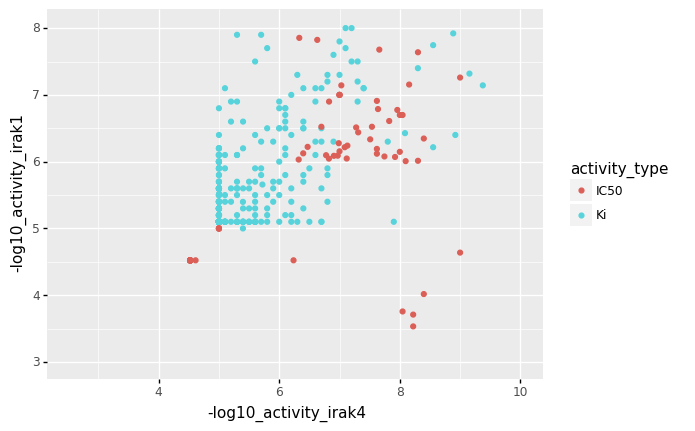

<ggplot: (418546788)>

In [86]:
ggplot(irak_data_pdb_purch)
+ aes(x="-log10_activity_irak4",
      y="-log10_activity_irak1",
      color="activity_type")
+ geom_point()